In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

In [2]:
df = pd.read_csv('./material/aCCF_0623_p_spec.csv')
df = df[df['Unnamed: 0'] % 2 == 0]
df['LATITUDE'] = df['LATITUDE'] * 111000
df['LONGITUDE'] = df['LONGITUDE'] * 85000
df = df.reset_index()
df = df.drop(columns=['index', 'Unnamed: 0'])
df

,LATITUDE,LONGITUDE,FL_hPa,TIME,MERGED,FL
0,3774000.0,-2550000.0,100,2018-06-23 06:00:00,0.113404,100
1,3774000.0,-2550000.0,100,2018-06-23 12:00:00,0.113514,100
2,3774000.0,-2550000.0,100,2018-06-23 18:00:00,0.113482,100
3,3774000.0,-2380000.0,100,2018-06-23 06:00:00,0.113423,100
4,3774000.0,-2380000.0,100,2018-06-23 12:00:00,0.113414,100
...,...,...,...,...,...,...
18223,6660000.0,2380000.0,600,2018-06-23 12:00:00,0.117499,360
18224,6660000.0,2380000.0,600,2018-06-23 18:00:00,0.117676,360
18225,6660000.0,2550000.0,600,2018-06-23 06:00:00,0.116333,360
18226,6660000.0,2550000.0,600,2018-06-23 12:00:00,0.118673,360


In [3]:
df_fuel = pd.read_csv('./material/bada_data.csv', delimiter='\t')
df_fuel = df_fuel[df_fuel['FL'] >= 100]
df_fuel['TAS-MS'] = df_fuel['TAS [kts]'] / 1.94384 # m/s
df_fuel = df_fuel.drop(columns=['TAS [kts]', 'TAS [kts].1', 'TAS [kts].2'])
df_fuel

,FL,fuel1,ROC [ft/min],fuel2,ROD [ft/min],fuel3,TAS-MS
9,100,40.3,2750,104.1,1680,8.4,148.674788
10,120,47.8,2670,99.4,2310,8.1,183.142645
11,140,47.6,2490,94.6,2340,7.9,188.287102
12,160,47.5,2310,89.8,2370,7.7,193.946004
13,180,47.3,2130,85.1,2400,7.5,199.604906
14,200,47.1,1940,80.5,2740,7.3,205.778253
15,220,46.9,1740,76.0,2760,7.1,211.951601
16,240,46.6,1550,71.6,2770,6.9,218.639394
17,260,46.4,1350,67.2,2780,6.7,225.327187
18,280,46.1,1150,62.9,2790,6.5,232.529426


In [64]:
time_grid = 1 # in seconds
total_time = []
uniques = {
    'LATITUDE': df['LATITUDE'].unique(),
    'LONGITUDE': df['LONGITUDE'].unique(),
    'FL': df['FL'].unique(),
    'TIME': [datetime.fromisoformat(x) for x in df['TIME'].unique()]
}
df_optimal = {(row['LATITUDE'], row['LONGITUDE'], row['FL'], datetime.fromisoformat(row['TIME'])): row['MERGED'] for [_, row] in df.iterrows()}

def get_distance(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2 + (p1[2]-p2[2])**2)

def get_closest(target, column):
    res = min(uniques[column], key = lambda x: abs(x - target))
    return res

def lookup_climate(x,y,z, t):
    start = datetime.now()
    #test = df[
    #    (df['LATITUDE'] == get_closest(x, 'LATITUDE')) & 
    #    (df['LONGITUDE'] == get_closest(y, 'LONGITUDE')) & 
    #    (df['FL'] == get_closest(z, 'FL')) & (df['TIME'] == get_closest(t, 'TIME'))
    #]['MERGED'].values[0]
    get_closest(t, 'TIME')
    test = df_optimal[(get_closest(x, 'LATITUDE'), get_closest(y, 'LONGITUDE'), get_closest(z, 'FL'), get_closest(t, 'TIME'))]
    end = datetime.now()
    total_time.append(end - start)
    return test
    
def turn_radius(v):
    return v**2 / 9.81 * np.tan(25 / 180 * np.pi)

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy
    

def point_on_circle(x,y,v, direction):
    
    r = turn_radius(v)
    [a, b] = [x, y + (-1 if direction == 'left' else 1) * r]
    d = v * time_grid
    t = d / r
    
    if t > np.pi / 2:
        warnings.warn('The airplane will make more than a 90° turn')
    
    # sin and cos swapped because we have y+ as a base
    return [
        a + r * np.sin(t),
        b + r * np.cos(t) * (-1 if direction == 'right' else 1),
        t
    ]

    
def lookup_path(x, y, z, t, alpha, path):
    row = df_fuel[df_fuel['FL'] == get_closest(z, 'FL')]
    v = row['TAS-MS'].values[0]
    if path == 'up':
        z_change = row['ROC [ft/min]'].values[0] / 60 * time_grid
        z_new = z + z_change / 100 
        distance = time_grid * v
        x_new = x + np.sqrt(distance ** 2 - z_change ** 2)
        fuel = row['fuel2'].values[0]
        y_new = y
        new_alpha = alpha
    elif path == 'down':
        z_change = row['ROD [ft/min]'].values[0] / 60 * time_grid
        z_new = z - z_change / 100 
        distance = time_grid * v
        x_new = x + np.sqrt(distance ** 2 - z_change ** 2)
        fuel = row['fuel3'].values[0]
        y_new = y
        new_alpha = alpha
    elif path == 'straight':
        z_new = z
        fuel = row['fuel1'].values[0]
        x_new = x + time_grid * v
        y_new = y
        new_alpha = alpha
    elif path == 'left':
        [x_new, y_new, delta_alpha] = point_on_circle(x,y,v, 'left')
        z_new = z
        fuel = row['fuel1'].values[0]
        new_alpha = alpha - (np.pi / 2 - delta_alpha)
    elif path == 'right':
        [x_new, y_new, delta_alpha] = point_on_circle(x,y,v, 'right')
        z_new = z
        fuel = row['fuel1'].values[0]
        new_alpha = alpha + (np.pi / 2 - delta_alpha)
        
    new_alpha = new_alpha % 2 * np.pi
    
    # rotate new coordinates
    [x_new, y_new] = rotate([x,y], [x_new, y_new], new_alpha)

    return {
        'coordinates': [x_new, y_new, z_new],
        'cost': lookup_climate(x_new, y_new, z_new, t + timedelta(seconds=time_grid)) * fuel,
        'time': t + timedelta(seconds=time_grid),
        'alpha': new_alpha
    }
    
    
def lookup_options(x, y, z, t, alpha):
    
    final_object = {
        'straight' : lookup_path(x,y,z,t, alpha, 'straight'),
        'left' : lookup_path(x,y,z,t, alpha, 'left'),
        'right' : lookup_path(x,y,z,t, alpha, 'right'),
    }
    
    if(z > 100):
        final_object['down'] = lookup_path(x,y,z,t, alpha, 'down')
        
    if(z < 400):
        final_object['up'] = lookup_path(x,y,z,t, alpha, 'up')
    
    return final_object


In [65]:
total = 0
start = datetime.now()
test = lookup_options(3774000, -2550000, 100, datetime(2018, 6, 23, 6, 1, 0), np.pi / 4.0)
end = datetime.now()
print(end - start)
print(sum(total_time, timedelta()))
test

0:00:00.001378
0:00:00.000097


{'straight': {'coordinates': [3773883.8534875195, -2549907.1873918055, 100],
  'cost': 4.570196932027458,
  'time': datetime.datetime(2018, 6, 23, 6, 1, 1),
  'alpha': 2.4674011002723395},
 'left': {'coordinates': [3773925.825192701, -2550128.706772965, 100],
  'cost': 4.570196932027458,
  'time': datetime.datetime(2018, 6, 23, 6, 1, 1),
  'alpha': 4.260322322430904},
 'right': {'coordinates': [3774109.1746854247, -2549899.261608572, 100],
  'cost': 4.570196932027458,
  'time': datetime.datetime(2018, 6, 23, 6, 1, 1),
  'alpha': 0.6744798781137756},
 'up': {'coordinates': [3773889.5102932183,
   -2549911.7077418338,
   100.45833333333333],
  'cost': 11.805397037817826,
  'time': datetime.datetime(2018, 6, 23, 6, 1, 1),
  'alpha': 2.4674011002723395}}

In [7]:
flights = pd.read_csv('./material/flights.csv', delimiter=';')
flights['start_time'] = pd.to_datetime('2018-06-23 '+ flights['start_time'])
flights['start_latitudinal'] = flights['start_latitudinal'] * 111000
flights['end_latitudinal'] = flights['end_latitudinal'] * 111000
flights['start_longitudinal'] = flights['start_longitudinal'] * 85000
flights['end_longitudinal'] = flights['end_longitudinal'] * 85000
flights

,flight_number,start_time,start_flightlevel,start_longitudinal,start_latitudinal,end_longitudinal,end_latitudinal
0,0,2018-06-23 07:15:00,250,-2550000,6216000,2040000,6660000
1,1,2018-06-23 07:10:00,310,-2550000,6216000,2550000,4662000
2,2,2018-06-23 07:50:00,250,-1870000,3774000,2550000,5106000
3,3,2018-06-23 07:30:00,260,-2210000,3774000,2380000,6660000
4,4,2018-06-23 07:00:00,230,-2550000,4662000,2550000,5106000
...,...,...,...,...,...,...,...
95,95,2018-06-23 06:10:00,260,-2550000,4440000,2210000,6660000
96,96,2018-06-23 07:05:00,200,-2550000,4662000,1870000,6660000
97,97,2018-06-23 06:00:00,300,-1190000,3774000,2550000,5772000
98,98,2018-06-23 07:30:00,310,-2550000,4440000,2550000,6216000


In [66]:
final_position = False

flight = flights.iloc[0]
x = flight['start_latitudinal']
y = flight['start_longitudinal']
z = flight['start_flightlevel']
t = flight['start_time']
alpha = np.random.random() * 2*np.pi
history = [{
    'coordinates': [x,y,z],
    'time': t,
    'cost': 0,
    'alpha': alpha
}]

def is_close(p1, p2):
    return get_distance(p1, p2) < 2000

def get_distance(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2 + (p1[2]-p2[2])**2)


while not final_position:
    options = lookup_options(x, y, z, t, alpha)
            
    for k in options.keys():
        options[k]['target_distance'] = get_distance(
            options[k]['coordinates'], 
            [flight['end_latitudinal'], flight['end_longitudinal'], flight['start_flightlevel']]
        )
        options[k]['total_cost'] =  options[k]['cost'] +  options[k]['target_distance'] * 0.001
        options[k]['direction'] = k
        
    next_step = min(options.values(), key = lambda x: x['total_cost'])
    [ x, y, z ] = next_step['coordinates']
    alpha = next_step['alpha']
    t = next_step['time']
    history.append(next_step)
    if len(history) % 50 == 0:
        print(next_step)
    
    if is_close(history[-1]['coordinates'], [flight['end_latitudinal'], flight['end_longitudinal'], flight['start_flightlevel']]):
        break

# while agent not in target
# get all options for current state
# pick best option or random option wi'th x chance
# move there
# record history

# finally record path and total cost

{'coordinates': [6216556.614435203, -2549021.310402445, 227.38666666666634], 'cost': 0.7081456982456035, 'time': Timestamp('2018-06-23 07:15:49'), 'alpha': 4.85767151364856, 'target_distance': 4610396.796810477, 'total_cost': 4611.104942508723, 'direction': 'down'}
{'coordinates': [6216175.149985425, -2547730.5998064447, 204.4266666666659], 'cost': 0.7400248009031553, 'time': Timestamp('2018-06-23 07:16:39'), 'alpha': 0.671050819012881, 'target_distance': 4609148.788655861, 'total_cost': 4609.888813456765, 'direction': 'down'}
{'coordinates': [6215322.310616889, -2546451.969390871, 182.61333333333212], 'cost': 0.7876871575078636, 'time': Timestamp('2018-06-23 07:17:29'), 'alpha': 3.907822033093691, 'target_distance': 4607958.3244106565, 'total_cost': 4608.746011568164, 'direction': 'down'}
{'coordinates': [6216770.676523845, -2546711.101213548, 162.70333333333176], 'cost': 0.7144590903532336, 'time': Timestamp('2018-06-23 07:18:19'), 'alpha': 1.3852374837039587, 'target_distance': 4608

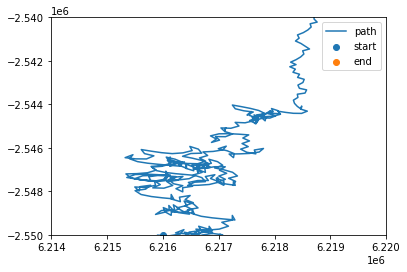

In [77]:
import matplotlib.pyplot as plt

x = np.array([x['coordinates'][0:2] for x in history])

plt.plot(x[:, 0], x[:, 1], label='path')
plt.scatter(flight['start_latitudinal'], flight['start_longitudinal'], label='start')
plt.scatter(flight['end_latitudinal'], flight['end_longitudinal'], label='end')
plt.xlim([6214000, 6220000])
plt.ylim([-2550000, -2540000])
plt.legend()

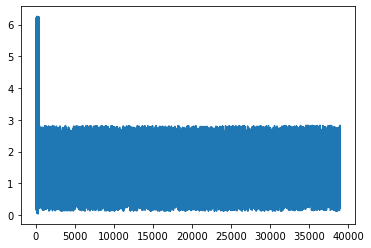

In [69]:
a = np.array([x['alpha'] for x in history])
plt.plot(a)

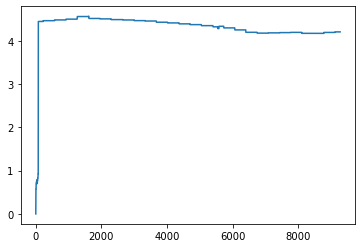

In [53]:
c = np.array([x['cost'] for x in history])
plt.plot(c)

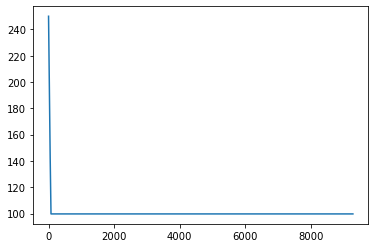

In [54]:
z = np.array([x['coordinates'][2] for x in history])
plt.plot(z)

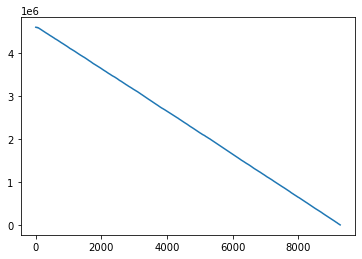

In [55]:
d = np.array([x['target_distance'] for x in history[1:]])
plt.plot(d)